In [1]:
%load_ext autoreload
%autoreload 2

import click
import pickle
from tqdm import tqdm
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sbi.inference import FMPE
import os
from utils.data_generation import fetch_grid, sample_joint_distribution, sample_uniform_distribution
from utils.inference import preprocess_inputs, get_prior, get_eval_grid, get_posterior, compute_indicators_sampling_posterior, posterior_and_prior_kdeplot
from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_regions
from lf2i.diagnostics.coverage_probability import compute_indicators_posterior

2024-12-17 12:12:40.952566: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 12:12:40.952605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 12:12:40.954231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 12:12:40.961784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 12:12:42.328141: W tensorflow/compiler/tf2

In [2]:
FLOW_TYPE = 'npe'
B = 300_000  # num simulations to estimate posterior anid test statistics
B_PRIME = 100_000  # num simulations to estimate critical values
B_DOUBLE_PRIME = 30_000  # num simulations to estimate coverage probability
EVAL_GRID_SIZE = 50_000
DISPLAY_GRID_SIZE = 10 # irrelevant now that grid has been defined elsewhere
NORM_POSTERIOR_SAMPLES = None
CONFIDENCE_LEVEL = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

POI_DIM = 5
POIS = ['t_eff', 'logg', 'feh_surf', 'logl', 'dist']
LABELS = [r"$T_{eff}$ (K)",
            r"$\log g$ (cgs)",
            r"$[\text{Fe/H}]_{\text{surf}}$ (relative to solar)",
            r"$\log L$ ($L_{\odot}$)",
            r"$d$ (kpc)"]
PRIOR_SETTINGS = [2.0, 1.0, 0.0, -1.0, -2.0]
PRIOR_ARGS = {
    'lower_bound' : torch.tensor([2.5e3, 0.0, -4.0, -1.5, 0.0]),
    'upper_bound' : torch.tensor([1.5e4, 5.0, 0.5, 3.5, 1.0e3])
}
PLOT_PRIORS = False # These figures have already been generated

assets_dir = f'{os.getcwd()}/assets'
os.makedirs(assets_dir, exist_ok=True)
params, seds = fetch_grid(assets_dir=assets_dir) # POI grid + raw SEDs

# 1. VIEW PRIORS

In [3]:
# Set up directories
prior_samples = []

for PRIOR_SETTING in PRIOR_SETTINGS:
    # Get prior
    try:
        with open(f'{assets_dir}/prior_{PRIOR_SETTING}.pkl', 'rb') as f:
            prior = pickle.load(f)
    except:
        theta, x = sample_joint_distribution(params=params,
                                            seds=seds,
                                            args={'age_feh_hyperparam': PRIOR_SETTING,},
                                            n_samples=B,
                                            assets_dir=assets_dir,)
        theta_p, x_p = preprocess_inputs(theta, x, ['t_eff', 'logg', 'feh_surf', 'logl', 'dist'])
        prior = get_prior(theta_p, prior_args=PRIOR_ARGS)
        with open(f'{assets_dir}/prior_{PRIOR_SETTING}.pkl', 'wb') as f:
            pickle.dump(prior, f)

    prior_samples.append(prior.sample((1_000,)))

if PLOT_PRIORS:
    theta_dfs = []
    # Convert theta to a pandas DataFrame
    for i, prior_sample in enumerate(prior_samples):
        theta_df_i = pd.DataFrame(prior_sample.numpy(), columns=LABELS)
        theta_df_i['set'] = str(i+1)
        theta_dfs.append(theta_df_i)

    # Convert theta to a pandas DataFrame
    theta_df = pd.concat(theta_dfs)

    # Create pairwise heatmaps
    palette = ["#ca0020", "#f4a582", "#f7f7f7", "#92c5de", "#0571b0"]
    g = sns.pairplot(data=theta_df,
                        hue='set',
                        palette=sns.color_palette(palette, 5),
                        kind='kde',
                        diag_kind='hist')

    for ax in g.axes.ravel():
        ax.invert_xaxis()
        ax.invert_yaxis()

    plt.savefig(f'{assets_dir}/prior_heatmap.png')

# 2. DATA GENERATION

## 2a. Look at clusters and display points

In [4]:
with open(f'{assets_dir}/tryout_display_grid.pkl', 'rb') as f:
    theta_p_d, x_p_d = pickle.load(f)
with open(f'{assets_dir}/tryout_display_grid_labels.pkl', 'rb') as f:
    display_labels = pickle.load(f)

In [5]:
theta_p_d.shape, x_p_d.shape, len(display_labels)

(torch.Size([72, 5]), torch.Size([72, 9]), 72)

## 2b. Make calibration dataset

In [6]:
try:
    with open(f'{assets_dir}/tryout_calibration_set.pkl', 'rb') as f:
        theta_p_c, x_p_c = pickle.load(f)
except:
    theta_c, x_c = sample_uniform_distribution(params, seds, B_PRIME)
    theta_p_c, x_p_c = preprocess_inputs(theta_c, x_c, POIS)
    with open(f'{assets_dir}/tryout_calibration_set.pkl', 'wb') as f:
        pickle.dump((theta_p_c, x_p_c), f)

if PLOT_PRIORS:
    theta_df = pd.DataFrame(theta_p_c, columns=LABELS)

    # Create pairwise heatmaps
    g = sns.pairplot(data=theta_df,
                        kind='hist',
                        diag_kind='hist')

    for ax in g.axes.ravel():
        ax.invert_xaxis()
        ax.invert_yaxis()

    plt.suptitle(f'Calibration set', fontsize=20)
    plt.savefig(f'{assets_dir}/calibration_histogram.png')

## 2c. Make evaluation grid

In [7]:
try:
    with open(f'{assets_dir}/tryout_evaluation_grid.pkl', 'rb') as f:
        theta_e_c, x_e_c = pickle.load(f)
except:
    theta_e, x_e = sample_uniform_distribution(params, seds, EVAL_GRID_SIZE)
    theta_e_c, x_e_c = preprocess_inputs(theta_e, x_e, POIS)
    with open(f'{assets_dir}/tryout_evaluation_grid.pkl', 'wb') as f:
        pickle.dump((theta_e_c, x_e_c), f)

if PLOT_PRIORS:
    theta_df = pd.DataFrame(theta_e_c, columns=LABELS)

    # Create pairwise heatmaps
    g = sns.pairplot(data=theta_df,
                        kind='hist',
                        diag_kind='hist')

    for ax in g.axes.ravel():
        ax.invert_xaxis()
        ax.invert_yaxis()

    plt.suptitle(f'Evaluation grid', fontsize=20)
    plt.savefig(f'{assets_dir}/evaluation_histogram.png')

## 2d. Make diagnostics dataset

In [8]:
try:
    with open(f'{assets_dir}/tryout_diagnostics_set.pkl', 'rb') as f:
        theta_p_g, x_p_g = pickle.load(f)
except:
    theta_c, x_c = sample_uniform_distribution(params, seds, B_DOUBLE_PRIME)
    theta_p_g, x_p_g = preprocess_inputs(theta_c, x_c, POIS)
    with open(f'{assets_dir}/tryout_diagnostics_set.pkl', 'wb') as f:
        pickle.dump((theta_p_g, x_p_g), f)

In [9]:
if PLOT_PRIORS:
    theta_df = pd.DataFrame(theta_p_g, columns=LABELS)

    # Create pairwise heatmaps
    g = sns.pairplot(data=theta_df,
                        kind='hist',
                        diag_kind='hist')

    for ax in g.axes.ravel():
        ax.invert_xaxis()
        ax.invert_yaxis()

    plt.suptitle(f'Diagnostics set', fontsize=20)
    plt.savefig(f'{assets_dir}/diagnostics_histogram.png')

# 3. Inference

As a sanity check, let's see how MAF looks

In [10]:
PRIOR_SETTING = 2.0
example_dir_for_setting = f'{os.getcwd()}/results/results_121624/example_{FLOW_TYPE}/setting_{PRIOR_SETTING}'
os.makedirs(example_dir_for_setting, exist_ok=True)

## 3a. Prior

In [11]:
# Get prior
try:
    with open(f'{assets_dir}/prior_{PRIOR_SETTING}.pkl', 'rb') as f:
        prior = pickle.load(f)
except:
    params, seds = fetch_grid(assets_dir=assets_dir)
    theta, x = sample_joint_distribution(params=params,
                                        seds=seds,
                                        args={'age_feh_hyperparam': PRIOR_SETTING,},
                                        n_samples=B,
                                        assets_dir=assets_dir,)
    theta_p, x_p = preprocess_inputs(theta, x, ['t_eff', 'logg', 'feh_surf', 'logl', 'dist'])
    prior = get_prior(theta_p, prior_args=PRIOR_ARGS)
    with open(f'{assets_dir}/prior_{PRIOR_SETTING}.pkl', 'wb') as f:
        pickle.dump(prior, f)

## 3b. Training set

In [12]:
try:
    with open(f'{assets_dir}/tryout_set_{PRIOR_SETTING}.pkl', 'rb') as f:
        theta_p, x_p = pickle.load(f)
except:
    params, seds = fetch_grid(assets_dir=assets_dir)
    theta, x = sample_joint_distribution(params=params,
                                        seds=seds,
                                        args={'age_feh_hyperparam': PRIOR_SETTING,},
                                        n_samples=B,
                                        assets_dir=assets_dir,)
    theta_p, x_p = preprocess_inputs(theta, x, POIS)
    with open(f'{assets_dir}/tryout_set_{PRIOR_SETTING}.pkl', 'wb') as f:
        pickle.dump((theta_p, x_p), f)

## 3c. Posterior

In [13]:
try:
    with open(f'{assets_dir}/posterior_{PRIOR_SETTING}_{FLOW_TYPE}.pkl', 'rb') as f:
        posterior = pickle.load(f)
except:
    posterior = get_posterior(theta_p, x_p, prior, flow_type=FLOW_TYPE)
    with open(f'{assets_dir}/posterior_{PRIOR_SETTING}_{FLOW_TYPE}.pkl', 'wb') as f:
        pickle.dump(posterior, f)

## 3d. LF2I

In [14]:
try:
    with open(f'{example_dir_for_setting}/lf2i.pkl', 'rb') as f:
        lf2i = pickle.load(f)
except:
    lf2i = LF2I(
        test_statistic=Posterior(
            poi_dim=POI_DIM, estimator=posterior, norm_posterior_samples=NORM_POSTERIOR_SAMPLES
        )
    )
    with open(f'{example_dir_for_setting}/lf2i.pkl', 'wb') as f:
        pickle.dump(lf2i, f)

## 3e. Credible regions

In [15]:
try:
    with open(f'{example_dir_for_setting}/credible_regions.pkl', 'rb') as f:
        credible_regions = pickle.load(f)
except:
    credible_regions = [
        hpd_region(
            posterior=lf2i.test_statistic.estimator,
            param_grid=posterior.sample((100_000,), x=true_x),
            x=true_x,
            credible_level=CONFIDENCE_LEVEL,
            num_level_sets=10_000,
        )
        for true_x in tqdm(x_p_d)
    ]
    with open(f'{example_dir_for_setting}/credible_regions.pkl', 'wb') as f:
        pickle.dump(credible_regions, f)

In [16]:
# param_space_df = pd.DataFrame(theta_e_c, columns=LABELS).sample(50_000)
# param_space_df['type'] = r'$\Theta$'

# for idx, (true_theta, region) in enumerate(zip(theta_p_d[:1], credible_regions[:1])):
#     region_df = pd.DataFrame(region[1], columns=LABELS)#.sample(min(50_000, len(region[1])))
#     region_df['type'] = 'HPD'
#     truth_df = pd.DataFrame(true_theta.unsqueeze(0).numpy(), columns=LABELS)
#     truth_df['type'] = 'Truth'
#     theta_df = pd.concat([param_space_df, region_df.sample(1), truth_df])

#     # Create pairwise heatmaps
#     palette = ["#808080", "#BF40BF", "#FF0000"]
#     g = sns.pairplot(data=theta_df,
#                         hue='type',
#                         palette=sns.color_palette(palette, 3),
#                         kind='hist',
#                         diag_kind='hist',)

#     for ax in g.axes.ravel():
#         if ax.get_xlabel() and ax.get_ylabel():
#             sns.scatterplot(data=truth_df, x=ax.get_xlabel(), y=ax.get_ylabel(), color='red', marker='*', s=100, ax=ax)
#             sns.scatterplot(data=region_df, x=ax.get_xlabel(), y=ax.get_ylabel(), color="#BF40BF", marker='.', s=1, ax=ax)
#         ax.invert_xaxis()
#         ax.invert_yaxis()

#     plt.suptitle(f'HPD Set ({display_labels[idx]})', fontsize=20)
#     # plt.savefig(f'{example_dir_for_setting}/hpd_for_pt_{display_labels[idx]}.png')
#     plt.show()

In [17]:
# truth_contained = []

# for idx, (true_x, true_theta) in enumerate(zip(x_p_d, theta_p_d)):
#     posterior_at_truth = lf2i.test_statistic.evaluate(parameters=true_theta.unsqueeze(0), samples=true_x.unsqueeze(0), mode='critical_values')
#     posterior_at_hpd = lf2i.test_statistic.evaluate(parameters=credible_regions[idx][1], samples=true_x.unsqueeze(0), mode='confidence_sets')
#     truth_contained.append(np.sum(posterior_at_truth > posterior_at_hpd) > 1)
#     if np.sum(posterior_at_truth > posterior_at_hpd) > 1:
#         print('HPD contains truth!')

In [18]:
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt

# # Convert theta_calib to a pandas DataFrame
# theta_calib_df = pd.DataFrame(theta_e_c, columns=LABELS)
# theta_display_df = pd.DataFrame(theta_p_d, columns=LABELS)
# theta_display_df['covered'] = truth_contained
# # theta_display_df['label'] = [f'{label}' for label in display_labels]

# # Plot pairplots
# g = sns.pairplot(data=theta_calib_df, diag_kind='hist', kind='hist')

# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         ax.text(point['x']-.2, point['y'], str(point['val']), fontsize=4)

# for ax in g.axes.ravel():
#     if ax.get_xlabel() and ax.get_ylabel():
#         sns.scatterplot(data=theta_display_df[truth_contained], x=ax.get_xlabel(), y=ax.get_ylabel(), marker='*', s=100, ax=ax, color='red')
#         # label_point(theta_display_df[ax.get_xlabel()], theta_display_df[ax.get_ylabel()], theta_display_df['label'], ax)
#     ax.invert_xaxis()
#     ax.invert_yaxis()

# plt.suptitle(f'Display grid', fontsize=20)
# # plt.savefig(f'{assets_dir}/display_grid_pairs.png')
# plt.show()
# plt.close()

## 3f. Confidence sets

In [ ]:
try:
    with open(f'{example_dir_for_setting}/confidence_sets.pkl', 'rb') as f:
        confidence_sets = pickle.load(f)
except:
    confidence_sets = [
        lf2i.inference( # TODO: LF2I returns failed QR (lack of coverage in all cases?)
            x=true_x.unsqueeze(0),
            evaluation_grid=torch.vstack([posterior.sample((100_000,), x=true_x.unsqueeze(0)),
                                        theta_e_c]),
            confidence_level=CONFIDENCE_LEVEL,
            calibration_method='critical-values',
            calibration_model='cat-gb',
            calibration_model_kwargs={
                'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
                'n_iter': 25
            },
            T_prime=(theta_p_c, x_p_c),
            retrain_calibration=False
        )[0]
        for true_x in tqdm(x_p_d)
    ]
    with open(f'{example_dir_for_setting}/confidence_sets.pkl', 'wb') as f:
        pickle.dump(confidence_sets, f)

In [29]:
def compute_lf2i_sampling_posterior(posterior, parameters, samples, credible_level, verbose=False, n_jobs=-2):
    from sbi.simulators.simutils import tqdm_joblib
    from joblib import Parallel, delayed
    from tqdm import tqdm
    import numpy as np

    def single_lf2i_set(idx):
        p = posterior
        confidence_set = lf2i.inference( # TODO: LF2I returns failed QR (lack of coverage in all cases?)
            x=samples[idx].unsqueeze(0),
            evaluation_grid=torch.vstack([p.sample((5_000,), x=samples[idx].unsqueeze(0)),
                                        theta_e_c,
                                        parameters[idx].unsqueeze(0)]),
            confidence_level=CONFIDENCE_LEVEL,
            calibration_method='critical-values',
            calibration_model='cat-gb',
            calibration_model_kwargs={
                'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
                'n_iter': 25
            },
            T_prime=(theta_p_c, x_p_c),
            retrain_calibration=False
        )[0]
        indicator = 1 if parameters[idx].unsqueeze(0).numpy() in confidence_set else 0
        return confidence_set, indicator

    with tqdm_joblib(tqdm(it:=range(samples.shape[0]), desc=f"Computing indicators for {len(it)} confidence sets", total=len(it), disable=not verbose)) as _:
        out = list(zip(*Parallel(n_jobs=n_jobs)(delayed(single_lf2i_set)(idx) for idx in it)))
    confidence_sets, indicators = out[0], np.array(out[1])
    return confidence_sets, indicators

In [30]:
confidence_sets, indicators = compute_lf2i_sampling_posterior(posterior, theta_p_d, x_p_d, CONFIDENCE_LEVEL, verbose=True, n_jobs=1)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:06<00:00,  6.48s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    3967 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.



Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:07<00:00,  7.57s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:06<00:00,  6.63s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:06<00:00,  6.32s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    3992 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.



Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:06<00:00,  6.38s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:06<00:00,  6.97s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:06<00:00,  6.70s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    3999 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.



Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    3993 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.



Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:08<00:00,  8.97s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:06<00:00,  6.18s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    3997 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.



Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:07<00:00,  7.24s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:06<00:00,  6.14s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    3996 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.



Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:07<00:00,  7.67s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:06<00:00,  6.26s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    3995 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.



Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:07<00:00,  7.91s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    3986 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.



Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    3993 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.



Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    3996 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.



Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:08<00:00,  8.96s/it]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    3998 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.



Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    3975 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.



Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]


Constructing confidence regions ...






Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

Computing indicators for 72 confidence sets: 100%|██████████| 72/72 [17:08<00:00, 14.28s/it]


In [32]:
with open(f'{example_dir_for_setting}/confidence_sets.pkl', 'wb') as f:
    pickle.dump(confidence_sets, f)

In [160]:
# param_space_df = pd.DataFrame(theta_e_c, columns=LABELS).sample(50_000)
# param_space_df['type'] = r'$\Theta$'

# for idx, (true_theta, region) in enumerate(zip(theta_p_d[:1], confidence_sets[:1])):
#     region_df = pd.DataFrame(region, columns=LABELS)#.sample(min(50_000, len(region[1])))
#     region_df['type'] = 'LF2I'
#     truth_df = pd.DataFrame(true_theta.unsqueeze(0).numpy(), columns=LABELS)
#     truth_df['type'] = 'Truth'
#     theta_df = pd.concat([param_space_df, region_df.sample(1), truth_df])

#     # Create pairwise heatmaps
#     palette = ["#808080", "#3cb371", "#FF0000"]
#     g = sns.pairplot(data=theta_df,
#                         hue='type',
#                         palette=sns.color_palette(palette, 3),
#                         kind='hist',
#                         diag_kind='hist',)

#     for ax in g.axes.ravel():
#         if ax.get_xlabel() and ax.get_ylabel():
#             sns.scatterplot(data=truth_df, x=ax.get_xlabel(), y=ax.get_ylabel(), color='red', marker='*', s=100, ax=ax)
#             sns.scatterplot(data=region_df, x=ax.get_xlabel(), y=ax.get_ylabel(), color="#3cb371", marker='.', s=5, ax=ax)
#         ax.invert_xaxis()
#         ax.invert_yaxis()

#     plt.suptitle(f'LF2I Set ({display_labels[idx]})', fontsize=20)
#     # plt.savefig(f'{example_dir_for_setting}/lf2i_for_pt_{display_labels[idx]}.png')
#     plt.show()

In [157]:
# param_space_df = pd.DataFrame(theta_e_c, columns=LABELS).sample(50_000)
# param_space_df['type'] = r'$\Theta$'

# for idx, (true_theta, region) in enumerate(zip(theta_p_d[:1], confidence_sets[:1])):
#     region_df = pd.DataFrame(region, columns=LABELS)#.sample(min(50_000, len(region[1])))
#     region_df['type'] = 'LF2I'
#     truth_df = pd.DataFrame(true_theta.unsqueeze(0).numpy(), columns=LABELS)
#     truth_df['type'] = 'Truth'
#     theta_df = pd.concat([param_space_df, region_df.sample(1), truth_df])

#     # Create pairwise heatmaps
#     palette = ["#808080", "#3cb371", "#FF0000"]
#     g = sns.pairplot(data=theta_df,
#                         hue='type',
#                         palette=sns.color_palette(palette, 3),
#                         kind='hist',
#                         diag_kind='hist',)

#     for ax in g.axes.ravel():
#         if ax.get_xlabel() and ax.get_ylabel():
#             sns.scatterplot(data=truth_df, x=ax.get_xlabel(), y=ax.get_ylabel(), color='red', marker='*', s=100, ax=ax)
#             sns.scatterplot(data=region_df[region_df['$d$ (kpc)'] < 0.5], x=ax.get_xlabel(), y=ax.get_ylabel(), color="#3cb371", marker='.', s=5, ax=ax)
#         ax.invert_xaxis()
#         ax.invert_yaxis()

#     plt.suptitle(f'LF2I Set ({display_labels[idx]})', fontsize=20)
#     # plt.savefig(f'{example_dir_for_setting}/lf2i_for_pt_{display_labels[idx]}.png')
#     plt.show()

In [158]:
# lf2i.inference( # TODO: LF2I returns failed QR (lack of coverage in all cases?)
#     x=x_p_d[0].unsqueeze(0),
#     evaluation_grid=torch.vstack([posterior.sample((100_000,), x=x_p_d[0].unsqueeze(0)),
#                                 theta_e_c]),
#     confidence_level=CONFIDENCE_LEVEL,
#     calibration_method='critical-values',
#     calibration_model='cat-gb',
#     calibration_model_kwargs={
#         'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
#         'n_iter': 25
#     },
#     T_prime=(theta_p_c[:10_000], x_p_c[:10_000]),
#     retrain_calibration=False
# )

In [159]:
# param_space_df = pd.DataFrame(theta_e_c, columns=LABELS).sample(1_000)
# param_space_df['type'] = r'$\Theta$'

# for idx, (true_theta, region) in enumerate(zip(theta_p_d[:10], confidence_sets[:10])):
#     region_df = pd.DataFrame(region, columns=LABELS)#.sample(min(1_000, len(region[1])))
#     region_df['type'] = 'LF2I'
#     truth_df = pd.DataFrame(true_theta.unsqueeze(0).numpy(), columns=LABELS)
#     truth_df['type'] = 'Truth'
#     theta_df = pd.concat([param_space_df, region_df, truth_df])

#     # Create pairwise heatmaps
#     palette = ["#808080", "#3cb371", "#FF0000"]
#     g = sns.pairplot(data=theta_df,
#                         hue='type',
#                         palette=sns.color_palette(palette, 3),
#                         kind='hist',
#                         diag_kind='hist',)

#     for ax in g.axes.ravel():
#         if ax.get_xlabel() and ax.get_ylabel():
#             sns.scatterplot(data=truth_df, x=ax.get_xlabel(), y=ax.get_ylabel(), color='red', marker='*', s=100, ax=ax)
#         ax.invert_xaxis()
#         ax.invert_yaxis()

#     plt.suptitle(f'LF2I Set ({display_labels[idx]})', fontsize=20)
#     # plt.savefig(f'{example_dir_for_setting}/lf2i_for_pt_{display_labels[idx]}.png')
#     plt.show()

## 3g. LF2I diagnostics

In [123]:
try:
    with open(f'{example_dir_for_setting}/lf2i_diagnostics.pkl', 'rb') as f:
        diagnostics_estimator, out_parameters, mean_proba, upper_proba, lower_proba = pickle.load(f)
except:
    diagnostics_estimator, out_parameters, mean_proba, upper_proba, lower_proba = lf2i.diagnostics(
        region_type='lf2i',
        calibration_method='critical-values',
        confidence_level=CONFIDENCE_LEVEL,
        coverage_estimator='cat-gb',
        coverage_estimator_kwargs={
            'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
            'n_iter': 25
        },
        T_double_prime=(theta_p_g, x_p_g),
        new_parameters=theta_e_c,
        n_jobs=-2,
        verbose=True,
    )
    with open(f'{example_dir_for_setting}/lf2i_diagnostics.pkl', 'wb') as f:
        pickle.dump((diagnostics_estimator, out_parameters, mean_proba, upper_proba, lower_proba), f)

In [53]:
ts = lf2i.test_statistic.evaluate(theta_p_g, x_p_g, mode='diagnostics')

Evaluating posterior for 30000 points ...:   0%|          | 8/30000 [00:08<6:15:29,  1.33it/s] /home/export/jcarzon/anaconda3/envs/vsi/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Evaluating posterior for 30000 points ...: 100%|██████████| 30000/30000 [06:14<00:00, 80.06it/s]


In [54]:
ts.shape

(30000,)

In [56]:
cv = lf2i.calibration_model['0.90'].predict(theta_p_g.numpy())

In [57]:
cv.shape

(30000,)

In [58]:
lf2i.test_statistic.acceptance_region

'right'

In [64]:
covered = (ts > cv).astype(int)

/tmp/user/3391/ipykernel_1500782/3574563488.py:7: RuntimeWarning: invalid value encountered in divide
  heatmap_values = binned_sum_proba / bin_counts


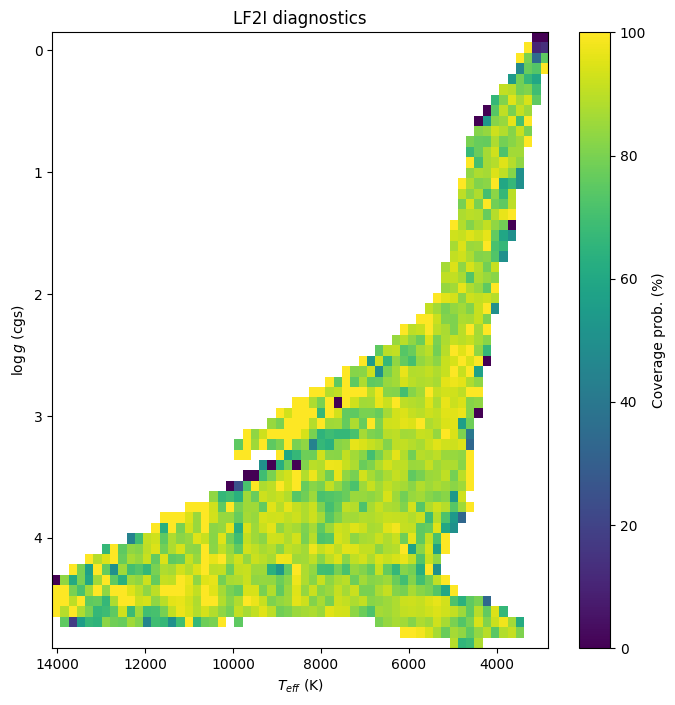

In [124]:
plt.figure(figsize=(8, 8))
theta_diag_df = pd.DataFrame(theta_p_g.numpy(), columns=LABELS)[LABELS[:2]]
x_bins = np.histogram_bin_edges(theta_diag_df[LABELS[0]], bins='auto')
y_bins = np.histogram_bin_edges(theta_diag_df[LABELS[1]], bins='auto')
binned_sum_proba, xedges, yedges = np.histogram2d(theta_diag_df[LABELS[0]], theta_diag_df[LABELS[1]], bins=[x_bins, y_bins], weights=np.round(covered*100, 2))
bin_counts, xedges, yedges = np.histogram2d(theta_diag_df[LABELS[0]], theta_diag_df[LABELS[1]], bins=[x_bins, y_bins])
heatmap_values = binned_sum_proba / bin_counts
heatmap = plt.imshow(heatmap_values.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(LABELS[0])
plt.ylabel(LABELS[1])
plt.title('LF2I diagnostics')
cb = plt.colorbar(heatmap, label='Coverage prob. (%)')
plt.savefig(f'{example_dir_for_setting}/lf2i_diagnostics.png')
plt.show()
plt.close()

## 3h. HPD Diagnostics

In [121]:
try:
    with open(f'{example_dir_for_setting}/hpd_diagnostics.pkl', 'rb') as f:
        diagnostics_estimator, out_parameters, mean_proba, upper_proba, lower_proba = pickle.load(f)
except:
    # Compute indicators.
    hpd_indicators = compute_indicators_sampling_posterior(posterior=posterior,
                                                            parameters=theta_p_g,
                                                            samples=x_p_g,
                                                            credible_level=CONFIDENCE_LEVEL,
                                                            verbose=True,
                                                            n_jobs=-2)

    ## Compute diagnostics.
    diagnostics_estimator, out_parameters, mean_proba, upper_proba, lower_proba = lf2i.diagnostics(
        region_type='posterior',
        confidence_level=CONFIDENCE_LEVEL,
        coverage_estimator='cat-gb',
        coverage_estimator_kwargs={
            'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
            'n_iter': 25
        },
        T_double_prime=(theta_p_g, x_p_g),
        new_parameters=theta_e_c,
        indicators=hpd_indicators,
        parameters=theta_p_g,
        n_jobs=-2,
        verbose=True,
    )
    with open(f'{example_dir_for_setting}/hpd_diagnostics.pkl', 'wb') as f:
        pickle.dump((diagnostics_estimator, out_parameters, mean_proba, upper_proba, lower_proba), f)

/tmp/user/3391/ipykernel_1500782/1830070308.py:7: RuntimeWarning: invalid value encountered in divide
  heatmap_values = binned_sum_proba / bin_counts


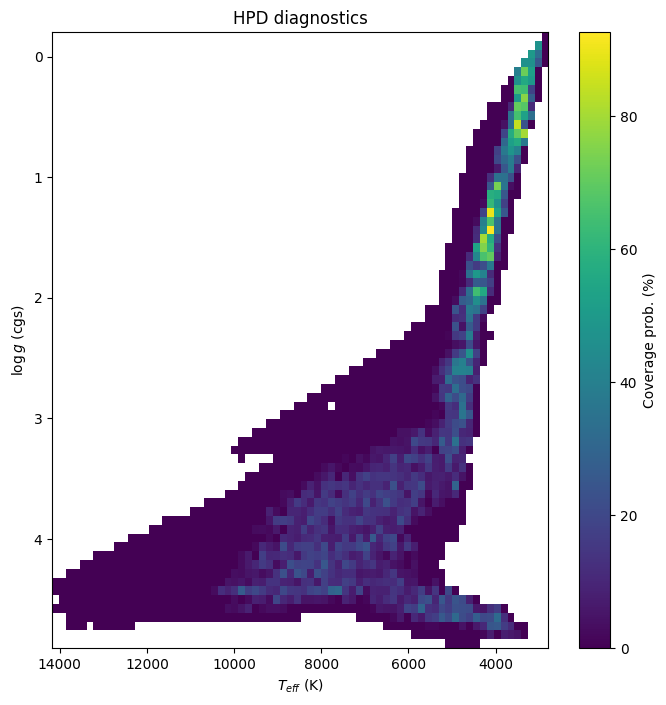

In [122]:
plt.figure(figsize=(8, 8))
theta_diag_df = pd.DataFrame(out_parameters, columns=LABELS)[LABELS[:2]]
x_bins = np.histogram_bin_edges(theta_diag_df[LABELS[0]], bins='auto')
y_bins = np.histogram_bin_edges(theta_diag_df[LABELS[1]], bins='auto')
binned_sum_proba, xedges, yedges = np.histogram2d(theta_diag_df[LABELS[0]], theta_diag_df[LABELS[1]], bins=[x_bins, y_bins], weights=np.round(mean_proba*100, 2))
bin_counts, xedges, yedges = np.histogram2d(theta_diag_df[LABELS[0]], theta_diag_df[LABELS[1]], bins=[x_bins, y_bins])
heatmap_values = binned_sum_proba / bin_counts
heatmap = plt.imshow(heatmap_values.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(LABELS[0])
plt.ylabel(LABELS[1])
plt.title('HPD diagnostics')
cb = plt.colorbar(heatmap, label='Coverage prob. (%)')
plt.savefig(f'{example_dir_for_setting}/hpd_diagnostics.png')
plt.show()
plt.close()

## 3i. Estimated coverage distribution for various targets

In [119]:
coverage_probs_for_setting = []

for PRIOR_SETTING in PRIOR_SETTINGS:
    # Test set
    try:
        with open(f'{assets_dir}/tryout_set_{PRIOR_SETTING}.pkl', 'rb') as f:
            theta_t, x_t = pickle.load(f)
    except:
        params, seds = fetch_grid(assets_dir=assets_dir)
        theta, x = sample_joint_distribution(params=params,
                                            seds=seds,
                                            args={'age_feh_hyperparam': PRIOR_SETTING,},
                                            n_samples=B,
                                            assets_dir=assets_dir,)
        theta_t, x_t = preprocess_inputs(theta, x, POIS)
        with open(f'{assets_dir}/tryout_set_{PRIOR_SETTING}.pkl', 'wb') as f:
            pickle.dump((theta_t, x_t), f)

    print(np.mean(diagnostics_estimator.predict_proba(theta_t.numpy())[:, 1]))
    coverage_probs_for_setting.append(diagnostics_estimator.predict_proba(theta_t.numpy())[:, 1])


0.7039266646653793
0.6756558923793524
0.5835472907130724
0.3456518019085686
0.20380926868479982


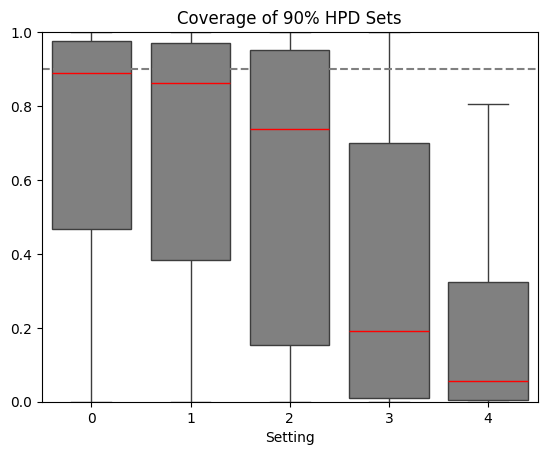

In [120]:
sns.boxplot(np.vstack(coverage_probs_for_setting).T, color='grey', medianprops=dict(color='red'), showfliers=False)
plt.title('Coverage of 90% HPD Sets')
plt.axhline(0.9, 0, 6, color='grey', linestyle='--')
plt.xlabel('Setting')
plt.ylim(0, 1)
plt.savefig(f'{assets_dir}/hpd_coverage_across_settings.png')
plt.show()
plt.close()

In [108]:
try:
    with open(f'{example_dir_for_setting}/lf2i_diagnostics.pkl', 'rb') as f:
        diagnostics_estimator, out_parameters, mean_proba, upper_proba, lower_proba = pickle.load(f)
except:
    diagnostics_estimator, out_parameters, mean_proba, upper_proba, lower_proba = lf2i.diagnostics(
        region_type='lf2i',
        calibration_method='critical-values',
        confidence_level=CONFIDENCE_LEVEL,
        coverage_estimator='cat-gb',
        coverage_estimator_kwargs={
            'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
            'n_iter': 25
        },
        T_double_prime=(theta_p_g, x_p_g),
        new_parameters=theta_e_c,
        n_jobs=-2,
        verbose=True,
    )
    with open(f'{example_dir_for_setting}/lf2i_diagnostics.pkl', 'wb') as f:
        pickle.dump((diagnostics_estimator, out_parameters, mean_proba, upper_proba, lower_proba), f)

In [109]:
coverage_probs_for_setting = []

for PRIOR_SETTING in PRIOR_SETTINGS:
    # Test set
    try:
        with open(f'{assets_dir}/tryout_set_{PRIOR_SETTING}.pkl', 'rb') as f:
            theta_t, x_t = pickle.load(f)
    except:
        params, seds = fetch_grid(assets_dir=assets_dir)
        theta, x = sample_joint_distribution(params=params,
                                            seds=seds,
                                            args={'age_feh_hyperparam': PRIOR_SETTING,},
                                            n_samples=B,
                                            assets_dir=assets_dir,)
        theta_t, x_t = preprocess_inputs(theta, x, POIS)
        with open(f'{assets_dir}/tryout_set_{PRIOR_SETTING}.pkl', 'wb') as f:
            pickle.dump((theta_t, x_t), f)

    print(np.mean(diagnostics_estimator.predict_proba(theta_t.numpy())[:, 1]))
    coverage_probs_for_setting.append(diagnostics_estimator.predict_proba(theta_t.numpy())[:, 1])


0.8950478719157673
0.8951282043368431
0.8953332844083345
0.8942582670789736
0.8909725397125051


In [116]:
sns.boxplot(np.vstack(coverage_probs_for_setting).T, color='grey', medianprops=dict(color='red'), showfliers=False)
plt.title('Coverage of 90% LF2I Sets')
plt.axhline(0.9, 0, 6, color='grey', linestyle='--')
plt.xlabel('Setting')
plt.ylim(0, 1)
plt.savefig(f'{example_dir_for_setting}/lf2i_coverage_across_settings.png')
plt.close()